Topic classification with BERTopic

Install transformers 4.41.0 for compatability with spacy and BERTopic

`pip install transformers==4.41.0` 

Careful when running this, very hardware intensive

In [1]:
import pandas as pd
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from umap import UMAP
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import psutil
from tqdm import tqdm
import re
import matplotlib.pyplot as plt

In [2]:
df_posts = pd.read_json('../data/dataset.json')
df_posts.head()

,timestamp,text,text_id,user,user_id
0,2024-10-31,Running a business means juggling countless ad...,2018569761,danielwoodard,1077866112
1,2024-10-31,Liz Truss is walking in the lingering shadow o...,2092717718,nelsonjacqueline,1089670430
2,2024-10-31,The UK is bracing for war as government buildi...,2059143248,ihooper,1007478642
3,2024-10-31,Marrying a second or third cousin once removed...,2008209828,wrightnicholas,1039258480
4,2024-10-31,It's truly disgraceful how the Indian National...,2001239278,michael51,1021455936


Apply minimal preprocessing (Remove URLs and Mentions)

In [3]:
df_posts['text'] = df_posts['text'].apply(lambda x: re.sub(r'http\S+|www\S+|https\S+|@\w+', '', x) if pd.notna(x) else x)

In [4]:
#df_posts = df_posts.sample(frac=0.1, random_state=42)  # 10% of the dataset

In [5]:
# Monitor memory usage
def monitor_memory():
    process = psutil.Process()
    memory_gb = process.memory_info().rss / 1024 / 1024 / 1024
    return f"Memory Usage: {memory_gb:.2f} GB"

# Create embeddings with memory monitoring and larger batches
def create_multifeature_embeddings(df_posts, sentence_model, batch_size=64):
    print(f"\nStarting embedding generation for {len(df_posts)} documents")
    print(monitor_memory())

    print("\nGenerating text embeddings...")
    text_embeddings = sentence_model.encode(
        df_posts['text'].fillna("").tolist(),
        batch_size=batch_size,
        show_progress_bar=True
    )
    print(monitor_memory())

    print(monitor_memory())
    return text_embeddings

# Set up and train BERTopic model with memory optimization
def setup_bertopic_model(df_posts, batch_size=64):
    print(f"\nDataset size: {len(df_posts)} documents")
    print(f"DataFrame memory usage: {df_posts.memory_usage().sum() / 1024**2:.2f} MB")
    print(monitor_memory())

    print("\nInitializing models...")
    sentence_model = SentenceTransformer('all-MiniLM-L6-v2')

    vectorizer_model = CountVectorizer(
        stop_words="english",
        #min_df = 350,  # Terms must appear in at least 350 rows (0.5% of dataset)
        #max_df = 0.8,  # Terms must appear in less than 80% of the dataset (56,000 rows)
        ngram_range=(1, 3) # Increase to include trigrams
    )

    umap_model = UMAP(
        n_neighbors=15,
        n_components=5,
        min_dist=0.0,
        metric='cosine',
        random_state=42
    )

    embeddings = create_multifeature_embeddings(df_posts, sentence_model, batch_size)

    topic_model = BERTopic(
        embedding_model=sentence_model,
        vectorizer_model=vectorizer_model,
        umap_model=umap_model,
        min_topic_size = 30,      # uncomment to set manual minimum topic size
        nr_topics='auto',
        calculate_probabilities=False,
        verbose=True
    )

    print("\nFitting BERTopic model...")
    topics, probs = topic_model.fit_transform(
        documents=df_posts['text'].fillna("").tolist(),
        embeddings=embeddings
    )

    return topic_model, topics, probs

# Analyze topics with memory considerations
def analyze_topics(topic_model, topics, df_posts):
    print("\nAnalyzing topics...")
    print(monitor_memory())

    topic_info = topic_model.get_topic_info()

    df_posts['topic'] = topics

    topic_docs = {}
    unique_topics = set(topics)
    print(f"\nFound {len(unique_topics)-1} topics (excluding -1)")

    for topic in tqdm(unique_topics):
        if topic != -1:
            topic_docs[topic] = df_posts[df_posts['topic'] == topic]['text'].head(3).tolist()

    try:
        print("\nGenerating visualizations...")
        topic_model.visualize_topics()
        topic_model.visualize_hierarchy()
    except Exception as e:
        print(f"Warning: Visualization error: {e}")

    return topic_info, topic_docs

# Run the complete pipeline with memory monitoring
def run_topic_analysis(df_posts, batch_size=64):
    print(f"Starting analysis with batch size: {batch_size}")
    print(monitor_memory())

    if 'text' not in df_posts.columns:
        raise ValueError("Missing required column: text")

    topic_model, topics, probs = setup_bertopic_model(df_posts, batch_size)
    topic_info, topic_docs = analyze_topics(topic_model, topics, df_posts)

    summary = {
        'num_topics': len(set(topics)) - 1,
        'topic_sizes': topic_info['Count'].tolist(),
        'top_topics': topic_info.head(10).to_dict('records')
    }

    return topic_model, summary, topics, probs

In [6]:
try:
    topic_model, summary, topics, probs = run_topic_analysis(df_posts, batch_size=64)
    
    print(f"\nAnalysis complete!")
    print(f"Found {summary['num_topics']} topics")
    print("\nTop 10 topics:")
    for topic in summary['top_topics']:
        print(f"Topic {topic['Topic']}: Size {topic['Count']}")
    
    topic_model.save("bertopic_model_large")
    
except Exception as e:
    print(f"Error during analysis: {e}")

Starting analysis with batch size: 64
Memory Usage: 0.63 GB

Dataset size: 70260 documents
DataFrame memory usage: 2.68 MB
Memory Usage: 0.63 GB

Initializing models...

Starting embedding generation for 70260 documents
Memory Usage: 0.73 GB

Generating text embeddings...


Batches:   0%|          | 0/1098 [00:00<?, ?it/s]

2025-01-26 20:42:42,888 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm


Memory Usage: 1.21 GB
Memory Usage: 1.21 GB

Fitting BERTopic model...


2025-01-26 20:43:40,165 - BERTopic - Dimensionality - Completed ✓
2025-01-26 20:43:40,165 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-01-26 20:43:43,328 - BERTopic - Cluster - Completed ✓
2025-01-26 20:43:43,329 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-01-26 20:43:48,155 - BERTopic - Representation - Completed ✓
2025-01-26 20:43:48,166 - BERTopic - Topic reduction - Reducing number of topics
2025-01-26 20:43:53,088 - BERTopic - Topic reduction - Reduced number of topics from 368 to 269



Analyzing topics...
Memory Usage: 2.17 GB

Found 268 topics (excluding -1)


100%|██████████| 269/269 [00:00<00:00, 4883.03it/s]


Generating visualizations...



2025-01-26 20:44:03,232 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.



Analysis complete!
Found 268 topics

Top 10 topics:
Topic -1: Size 26107
Topic 0: Size 3373
Topic 1: Size 1937
Topic 2: Size 1638
Topic 3: Size 1378
Topic 4: Size 1315
Topic 5: Size 1246
Topic 6: Size 1035
Topic 7: Size 950
Topic 8: Size 909


In [7]:
# 1. Save visualizations to HTML files
fig = topic_model.visualize_barchart(top_n_topics=20)
fig.write_html("../output/topic_barchart.html")

topic_model.visualize_topics().write_html("../output/topic_clusters.html")
topic_model.visualize_hierarchy().write_html("../output/topic_hierarchy.html")

# 2. Print text-based summary
topics_info = topic_model.get_topic_info()
print("\nMost frequent topics with their terms:")
for _, row in topics_info.head(20).iterrows():
    topic_id = row['Topic']
    size = row['Count']
    if topic_id != -1:
        terms = topic_model.get_topic(topic_id)
        print(f"\nTopic {topic_id} (Size: {size}):")
        # Print top 10 terms for each topic with their weights
        for term, weight in terms[:20]:
            print(f"  - {term}: {weight:.3f}")


Most frequent topics with their terms:

Topic 0 (Size: 3373):
  - vote: 0.021
  - social artist: 0.019
  - btsbbmas: 0.019
  - artist: 0.017
  - bbmas: 0.016
  - social: 0.016
  - voting: 0.016
  - army: 0.015
  - counts: 0.013
  - vote counts: 0.012

Topic 1 (Size: 1937):
  - science: 0.030
  - research: 0.006
  - scientific: 0.006
  - stem: 0.005
  - fascinating: 0.005
  - innovation: 0.004
  - sciencematters: 0.004
  - universe: 0.004
  - math: 0.004
  - lab: 0.004

Topic 2 (Size: 1638):
  - politics: 0.019
  - political: 0.008
  - unity: 0.007
  - corruption: 0.007
  - accountability: 0.006
  - people: 0.005
  - time: 0.005
  - tories: 0.005
  - change: 0.004
  - like: 0.004

Topic 3 (Size: 1378):
  - business: 0.014
  - entrepreneurship: 0.013
  - marketing: 0.009
  - success: 0.009
  - online: 0.008
  - businessgrowth: 0.007
  - seo: 0.007
  - social media: 0.007
  - online business: 0.006
  - media: 0.005

Topic 4 (Size: 1315):
  - secretary: 0.016
  - health secretary: 0.015
 

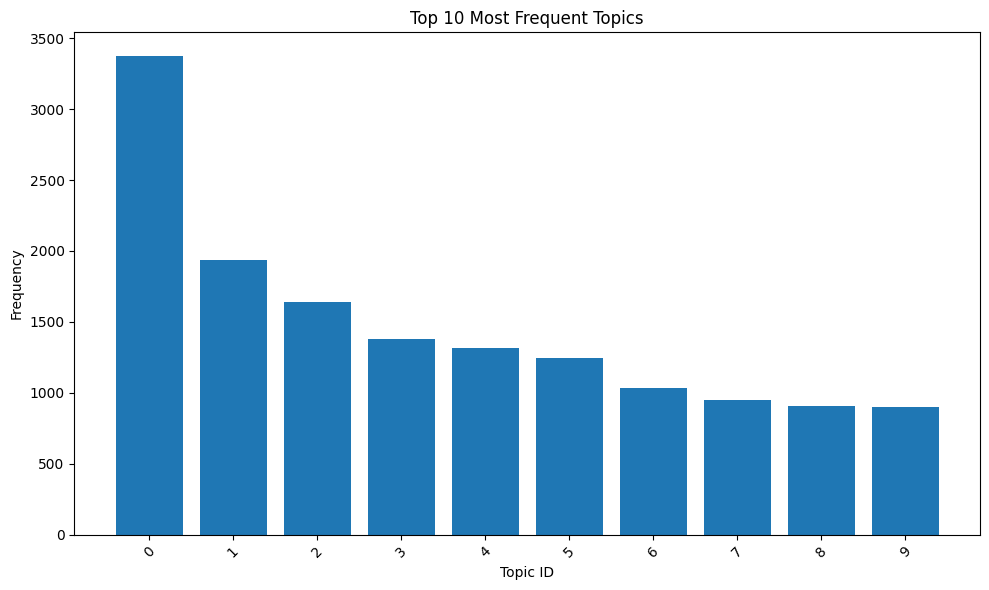

In [8]:
# 1. Retrieve topic information
topics_info = topic_model.get_topic_info()

# 2. Filter out the outlier topic (topic_id = -1) if you want
topics_info_filtered = topics_info[topics_info.Topic != -1]

# 3. Select top N topics
top_n = 10
top_topics = topics_info_filtered.head(top_n)

# 4. Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(range(len(top_topics)), top_topics["Count"])
plt.xticks(range(len(top_topics)), top_topics["Topic"], rotation=45)
plt.xlabel("Topic ID")
plt.ylabel("Frequency")
plt.title(f"Top {top_n} Most Frequent Topics")
plt.tight_layout()
plt.show()

In [9]:
# Transform documents into topics and probabilities
#documents = df_posts['text'].tolist()
#topics, probs = topic_model.transform(documents)

# Reassign "Other" topics to the most probable topic
#import numpy as np
#for i, prob in enumerate(probs):
#    if topics[i] == -1:  # Check for "Other"
#        topics[i] = np.argmax(prob)  # Assign the most probable topic

# Add topic numbers to the dataframe
#df_posts['topic'] = topics

# Generate topic labels
#topic_labels = {}
#for topic_id in set(topics):
#    if topic_id != -1:
#        terms = topic_model.get_topic(topic_id)
#        topic_labels[topic_id] = ", ".join([term for term, _ in terms[:3]])
#    else:
#        topic_labels[topic_id] = "Other"

# Add descriptive topic labels to the dataframe
#df_posts['topic_label'] = df_posts['topic'].map(topic_labels)

# Save augmented dataframe
#df_posts.to_csv('../output/posts_with_topics.csv', index=False)

In [10]:
# 
documents = df_posts['text'].tolist()
topics, probs = topic_model.transform(documents)

# Handle "Other" first
num_others = np.sum(np.array(topics) == -1)
for i, prob in enumerate(probs):
    if topics[i] == -1:
        topics[i] = np.argmax(prob)

# Reduce topics to a smaller number for feature clustering
topic_model.reduce_topics(documents, nr_topics=30)

# Generate labels for the topics
topic_labels = {topic_id: ", ".join([term for term, _ in topic_model.get_topic(topic_id)[:3]]) 
               for topic_id in set(topics) if topic_id != -1}
topic_labels[-1] = "Other"

df_posts['topic'] = topics
df_posts['topic_label'] = df_posts['topic'].map(topic_labels)
df_posts.to_csv('../output/posts_with_topics.csv', index=False)

Batches:   0%|          | 0/2196 [00:00<?, ?it/s]

2025-01-26 20:47:53,368 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2025-01-26 20:48:03,505 - BERTopic - Dimensionality - Completed ✓
2025-01-26 20:48:03,506 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2025-01-26 20:48:07,367 - BERTopic - Cluster - Completed ✓
2025-01-26 20:48:07,446 - BERTopic - Topic reduction - Reducing number of topics
2025-01-26 20:48:12,324 - BERTopic - Topic reduction - Reduced number of topics from 269 to 30


TypeError: 'bool' object is not subscriptable